<a href="https://colab.research.google.com/github/RJZauner/mnist_GAN/blob/main/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Generative Adversiarial Network using Tensorflow

This notebook demonstrates the use of the Tensorflow library to build a Generative Adversarial Network that generates handwritten images of digits. The dataset used for this experiment is the MNIST dataset that forms part of the Tensorflow library.

The tutorial uses a deep convolutional GAN (DCGAN) that was introduced in the paper: [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf).

## Deployment

For testing and demonstration purposes, I would suggest using [Gradio](https://gradio.app). It helps to get interact with the model and get a feel for its behaviour.

Deployment would be most likely through a web service using a REST API.

## Generative Adversarial Networks
These architectures enable neural networks to output new data points such as text, images, videos etc.

They consist of a generator model and a discriminator model. The generator is responsible for creating these new data points, while the discriminator tries to decide, whether the input it is receiving from the generator, is a real or a synthetically generated one.

The result from classification made by the discriminator is then used to update the weights of the generator. 

This means that your discriminator needs to be good, otherwise the result from your generator will be poor.

The discriminator and generator are trained in parallel - with each epoch they both update their respective weights and improve. 

There is a catch: If your discriminator improves quicker than your generator, your generator will not improve beyond a certain point.

## Source

The code is available from the tensorflow tutorial: https://www.tensorflow.org/tutorials/generative/dcgan 

In [ ]:
# Import Tensorflow
import tensorflow as tf

# Version Check
tf.__version__

'2.8.0'

In [ ]:
# Import libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# MNIST Handwritten Digits

Let us have a look at the dataset used for this tutorial.

11501568/11490434 [==============================] - 0s 0us/step


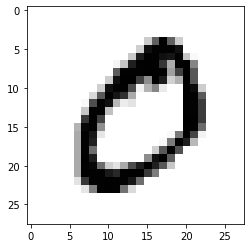

In [ ]:
# Download dataset for experiment
mnist = tf.keras.datasets.mnist

# Split Data
(train_images, train_labels), (x_test, y_test) = mnist.load_data()

# Plot image to check
plt.imshow(train_images[1], cmap='gray_r')

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator

Using a convolutional neural network architecture is a common practice when dealing with vision tasks.

This tutorial also makes use of this architecture when designing the network.

## Architecture
- Convolutional layers (Conv2DTranspose) for upsampling
- LeakyReLu is as an activation function for all but the final layer (Paper suggests using LeakyReLu only in discriminator)
- tanh activation is used for the final layer
- BatchNormalization is used (Paper suggests using it in both, generator and discriminator - here it is only used within the generator)


In [ ]:
# Build the Generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

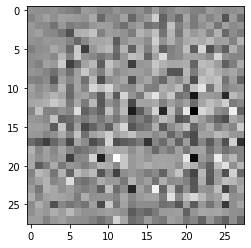

In [ ]:
# Generate an image
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Discriminator

A classification model that classifies the output from our generator.

## Architecture
- Convolutional Neural Network
- LeakyReLu Activation Function is used
- No BatchNormalization as suggested in the paper

In [ ]:
# Build the discriminiator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Classify generated image as real or fake
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00174783]], shape=(1, 1), dtype=float32)


# Loss Function

Seeing as this is a binary classifier, the authors of the tutorial make use of the BinaryCrossnetropy as our loss function.

In [ ]:
# Create loss func
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer
Just as the paper suggests, the authors of the tutorial also make use of the Adam optimizer set to a value of 0.0001.

In [ ]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Define checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Training
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Training Loop
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

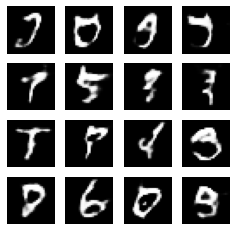

In [ ]:
train(train_dataset, EPOCHS)